In [1]:
%matplotlib inline

import anndata
import fastcluster
import matplotlib
from matplotlib import pyplot
from matplotlib_venn import venn2, venn2_circles
import numpy
import os
import pandas
import scanpy as sc
from scipy import stats
from scipy.cluster import hierarchy
import seaborn
from statannotations.Annotator import Annotator
import sys

print(f'Package versions:\nPython {sys.version}, anndata {anndata.__version__}, fastcluster {fastcluster.__version__}, '
      f'matplotlib {matplotlib.__version__}, matplotlib-venn {sys.modules["matplotlib_venn"].__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, scanpy {sc.__version__}, scipy {sys.modules["scipy"].__version__}, '
      f'seaborn {seaborn.__version__}, statannotations {sys.modules["statannotations"].__version__}')

Package versions:
Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0], anndata 0.9.1, fastcluster 1.2.6, matplotlib 3.7.1, matplotlib-venn 1.1.1, numpy 1.23.5, pandas 2.0.0, scanpy 1.9.3, scipy 1.10.1, seaborn 0.12.2, statannotations 0.7.1


## RNA-seq data

In [2]:
# Found this function here: https://gist.github.com/slowkow/c6ab0348747f86e2748b
# Looks correct. This is a good explanation of RPKM vs TPM: https://btep.ccr.cancer.gov/question/faq/what-is-the-difference-between-rpkm-fpkm-and-tpm/
def read_counts2tpm(anndata_obj, gene_lens='Length', raw_counts_layer='raw_counts'):
    """
    convert read counts to TPM (transcripts per million)
    :param df: a dataFrame containing read counts from each gene (rows) and each sample (columns)
    :param sample_names: list or array of sample names
    :param gene_lens: series of gene or transcript lengths
    :return: TPM
    """
    sample_reads = anndata_obj.layers[raw_counts_layer].copy()
    if isinstance(gene_lens, str):
        gene_lens = anndata_obj.var[gene_lens].to_numpy()
    elif len(gene_lens) != anndata_obj.shape[1]:
        raise Exception('The value of gene_lens must be either the name of the anndata_obj.var column '
                        'that contains the transcript lengths or an iterable specifying '
                        'length values for each gene.')
    rate = sample_reads / gene_lens
    tpm = (rate.T / numpy.sum(rate, axis=1)).T * 1e6
    return numpy.nan_to_num(tpm)

In [3]:
# load sample metadata from Table S2
rna_samples = pandas.read_excel('./Table S2.xlsx', sheet_name='sample metadata')
rna_samples['mouse_id'] = rna_samples['mouse_id'].astype(str)
rna_samples = rna_samples.set_index('mouse_id', drop=False)

# load gene metadata from Table S2
rna_genes = pandas.read_excel('./Table S2.xlsx', sheet_name='gene metadata', index_col=0)

# load raw counts from Table S2
rna_raw = pandas.read_excel('./Table S2.xlsx', sheet_name='raw counts', index_col=0).T
rna_raw.index = rna_raw.index.astype(str)

# make AnnData object
rna_data = anndata.AnnData(X=rna_raw, obs=rna_samples, var=rna_genes)
rna_data.layers['raw_counts'] = rna_data.X.copy()

# TPM normalization
rna_data.X = read_counts2tpm(rna_data)
rna_data.layers['tpm_counts'] = rna_data.X.copy()

# remove filtered samples
outlier_samples = ['164', '182', '191', '218', '213', '214']
rna_data = rna_data[~rna_data.obs.index.isin(outlier_samples)]

# load batch-corrected TPM counts from Table S2
rna_bc_tpm = pandas.read_excel('./Table S2.xlsx', sheet_name='batch corrected TPM counts', index_col=0).T
rna_bc_tpm.index = rna_bc_tpm.index.astype(str)

rna_data = rna_data[:,rna_bc_tpm.columns]
rna_data.layers['tpm_counts_bc'] = rna_bc_tpm

rna_data

AnnData object with n_obs × n_vars = 42 × 19601
    obs: 'mouse_id', 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition', 'pole_test_sec', 'cage_test_sec'
    var: 'common_name', 'Length', 'highly_variable', 'expressed'
    layers: 'raw_counts', 'tpm_counts', 'tpm_counts_bc'

In [4]:
disp_label_map = {'PFF_hypoxia':'11% $\mathrm{O}_2$, PFF', 'PFF_normoxia':'21% $\mathrm{O}_2$, PFF',
                  'monomer_hypoxia':'11% $\mathrm{O}_2$, mon.', 'monomer_normoxia':'21% $\mathrm{O}_2$, mon.'}
rna_data.obs['exp_condition_disp'] = [disp_label_map[elt] for elt in rna_data.obs['exp_condition'].values]
hue_order = ['21% $\mathrm{O}_2$, mon.', '21% $\mathrm{O}_2$, PFF', '11% $\mathrm{O}_2$, mon.', '11% $\mathrm{O}_2$, PFF']
color_list = [tuple(list(elt) + [1.0]) for elt in list(numpy.array([[176,176,176], [197,167,167], [102,102,102], [131,38,38]])/256)]
color_dict = dict(zip(hue_order, color_list))
print(color_list)

[(0.6875, 0.6875, 0.6875, 1.0), (0.76953125, 0.65234375, 0.65234375, 1.0), (0.3984375, 0.3984375, 0.3984375, 1.0), (0.51171875, 0.1484375, 0.1484375, 1.0)]


In [5]:
rna_mono_hyp_vs_norm = pandas.read_excel('./Table S2.xlsx', sheet_name='monomer hyp vs monomer norm')
rna_mono_hyp_vs_norm['comparison'] = 'MonomerHypoxia_vs_MonomerNormoxia'

rna_mono_vs_pff_norm = pandas.read_excel('./Table S2.xlsx', sheet_name='PFF norm vs monomer norm')
rna_mono_vs_pff_norm['comparison'] = 'PFFNormoxia_vs_MonomerNormoxia'

#### Fig 3e

In [6]:
goi = ['Vegfa', 'Kdr', 'Adm', 'Ldha', 'Cxcl12', 'Slc16a3', 'Ndufa4l2']
goi_subset = rna_data[:,rna_data.var['common_name'].isin(goi)].copy()
goi_subset.var['common_name'] = goi_subset.var['common_name'].astype(str)
goi_subset.var = goi_subset.var.reset_index().set_index('common_name', drop=False)

to_plot = rna_data.obs.copy()
to_plot[goi] = goi_subset.to_df(layer='tpm_counts')[goi]

#normalize to 21% O2, mon.
to_plot[goi] = to_plot[goi].values/to_plot.loc[to_plot['exp_condition'] == 'monomer_normoxia', goi].mean().values

to_plot = to_plot.melt(id_vars=['mouse_id', 'exp_condition_disp'], value_vars=goi, var_name='common_name', value_name='Normalized TPM')
print(to_plot.shape)
to_plot.head()

(294, 4)


,mouse_id,exp_condition_disp,common_name,Normalized TPM
0,159,"21% $\mathrm{O}_2$, PFF",Vegfa,0.921088
1,160,"21% $\mathrm{O}_2$, PFF",Vegfa,0.998987
2,161,"21% $\mathrm{O}_2$, PFF",Vegfa,0.857059
3,162,"21% $\mathrm{O}_2$, PFF",Vegfa,0.890704
4,163,"11% $\mathrm{O}_2$, PFF",Vegfa,1.804082


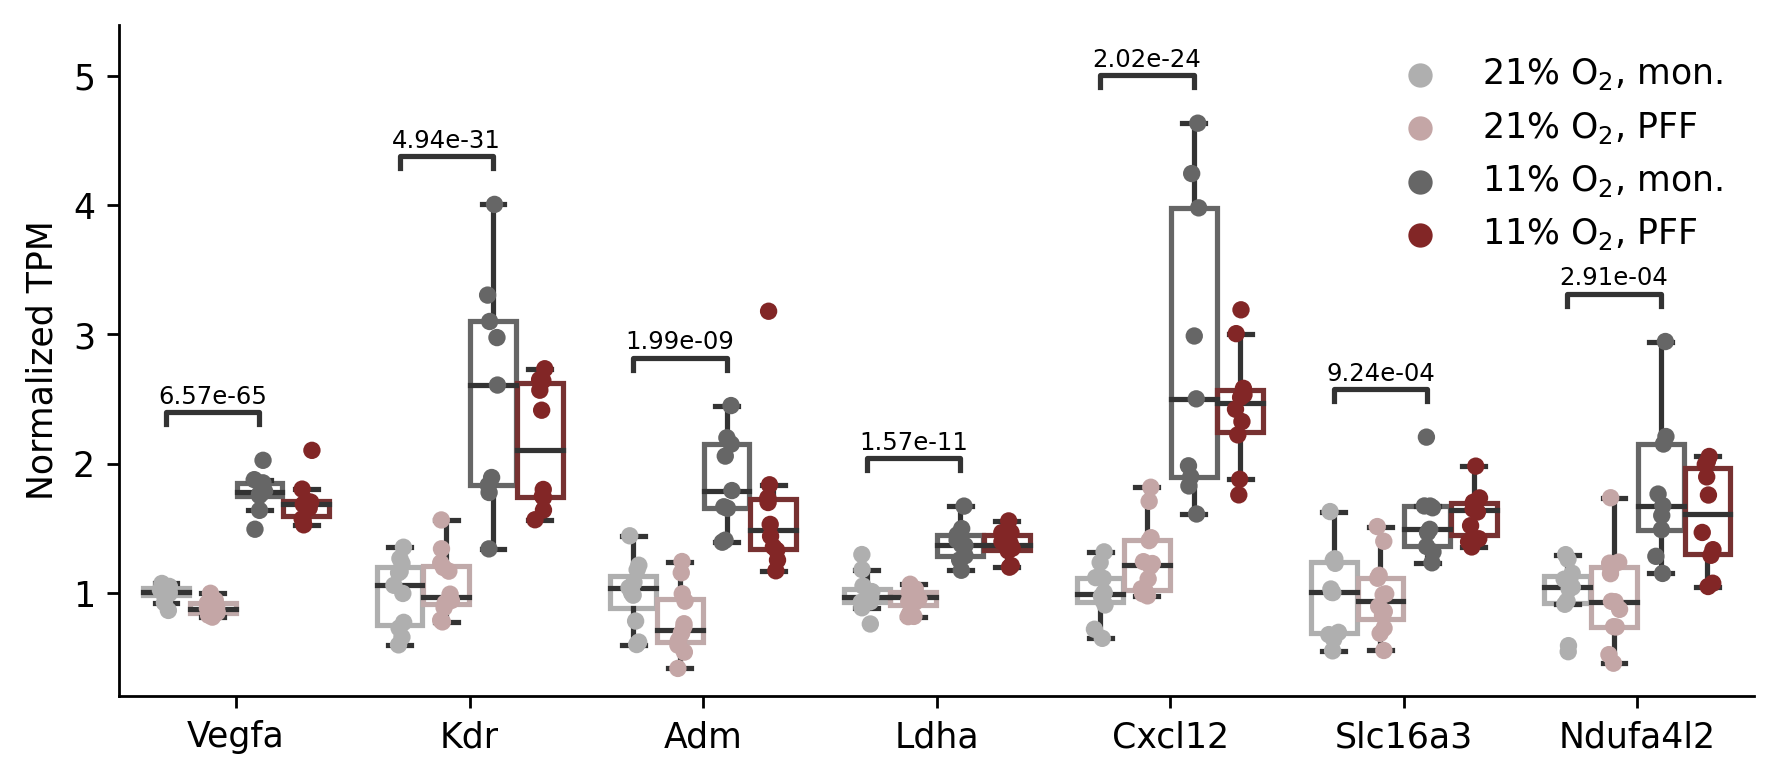

In [7]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,3), dpi=250, layout='constrained')

plotting_params = {'data':to_plot, 'x':'common_name', 'y':'Normalized TPM', 'order':goi,
                   'hue':'exp_condition_disp', 'hue_order':hue_order, 'palette':color_dict}

seaborn.boxplot(**plotting_params, showfliers=False, ax=axes)
seaborn.stripplot(**plotting_params, dodge=True, ax=axes)

axes.set_xlabel('')
axes.set_xlim(-0.5,len(goi)-0.5)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# Add annotations
pairs = [[(elt,'21% $\mathrm{O}_2$, mon.'), (elt, '11% $\mathrm{O}_2$, mon.')] for elt in goi]
pvals = rna_mono_hyp_vs_norm.set_index('common_name').loc[goi, 'padj'].values
formatted_pvals = [f'{elt:0.2e}' for elt in pvals]
annotator = Annotator(axes, pairs, **plotting_params)
annotator.configure(verbose=False)
annotator._pvalue_format.fontsize = 7
annotator.set_custom_annotations(formatted_pvals)
annotator.annotate()

for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
    patch.set_edgecolor((r, g, b, 1))
    
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[-4:], labels[-4:], bbox_to_anchor=[1,1], frameon=False)

fig.show()
#fig.tight_layout()

#### Fig 3c

In [8]:
goi = 'Tfrc'
goi_subset = rna_data[:,rna_data.var['common_name'] == goi].copy()
goi_subset.var['common_name'] = goi_subset.var['common_name'].astype(str)
goi_subset.var = goi_subset.var.reset_index().set_index('common_name', drop=False)

to_plot = rna_data.obs.copy()
to_plot[goi] = goi_subset.to_df(layer='tpm_counts')[goi]

#normalize to 21% O2, mon.
to_plot[goi] = to_plot[goi].values/to_plot.loc[to_plot['exp_condition'] == 'monomer_normoxia', goi].mean()

to_plot = to_plot.melt(id_vars=['mouse_id', 'exp_condition_disp'], value_vars=goi, var_name='common_name', value_name='Normalized TPM')
print(to_plot.shape)
to_plot.head()

(42, 4)


,mouse_id,exp_condition_disp,common_name,Normalized TPM
0,159,"21% $\mathrm{O}_2$, PFF",Tfrc,1.209068
1,160,"21% $\mathrm{O}_2$, PFF",Tfrc,1.255872
2,161,"21% $\mathrm{O}_2$, PFF",Tfrc,1.389193
3,162,"21% $\mathrm{O}_2$, PFF",Tfrc,1.346497
4,163,"11% $\mathrm{O}_2$, PFF",Tfrc,1.801551


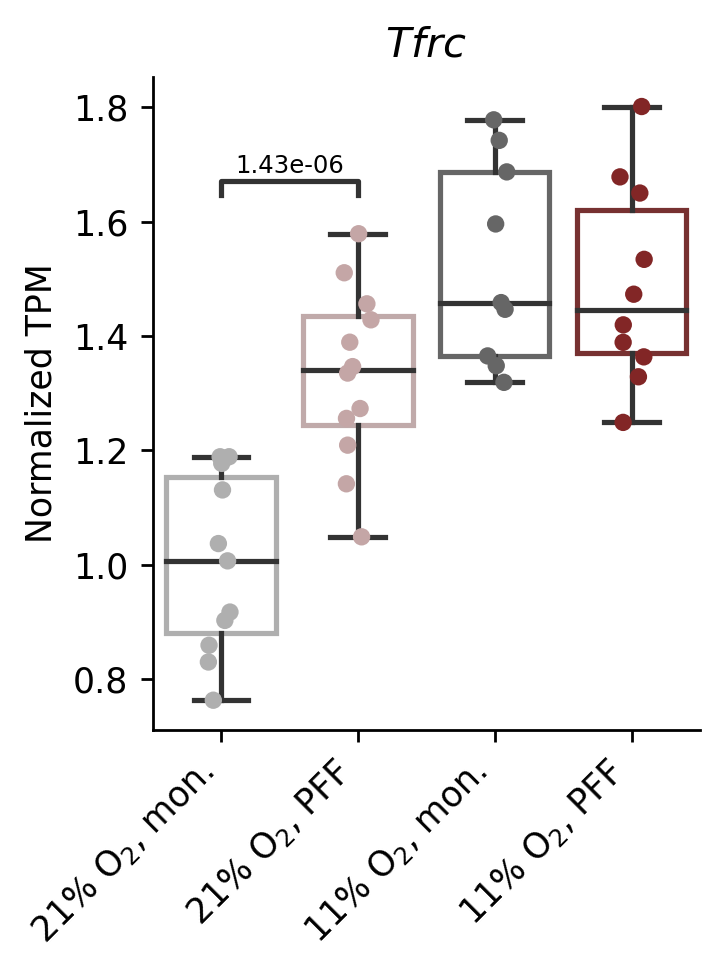

In [9]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(3,4), dpi=250)

plotting_params = {'data':to_plot, 'x':'exp_condition_disp', 'y':'Normalized TPM', 'order':hue_order, 
                   'hue':'exp_condition_disp', 'hue_order':hue_order, 'palette':color_dict, 'dodge':False}

seaborn.boxplot(**plotting_params, showfliers=False, ax=axes)
seaborn.stripplot(**plotting_params, ax=axes)

axes.set_xlabel('')
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_title('$\it{Tfrc}$')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend_.remove()

# Add annotations
pairs = [('21% $\mathrm{O}_2$, mon.', '21% $\mathrm{O}_2$, PFF')]
pvals = rna_mono_vs_pff_norm.set_index('common_name').loc[[goi], 'padj'].values
formatted_pvals = [f'{elt:0.2e}' for elt in pvals]
annotator = Annotator(axes, pairs, **plotting_params)
annotator.configure(verbose=False)
annotator._pvalue_format.fontsize = 7
annotator.set_custom_annotations(formatted_pvals)
annotator.annotate()

for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
    patch.set_edgecolor((r, g, b, 1))
    
#handles, labels = axes.get_legend_handles_labels()
#axes.legend(handles[-4:], labels[-4:], bbox_to_anchor=[1,1], frameon=False)

fig.tight_layout()

#### Fig 3d

In [10]:
goi = 'Slc40a1'
goi_subset = rna_data[:,rna_data.var['common_name'] == goi].copy()
goi_subset.var['common_name'] = goi_subset.var['common_name'].astype(str)
goi_subset.var = goi_subset.var.reset_index().set_index('common_name', drop=False)

to_plot = rna_data.obs.copy()
to_plot[goi] = goi_subset.to_df(layer='tpm_counts')[goi]

#normalize to 21% O2, mon.
to_plot[goi] = to_plot[goi].values/to_plot.loc[to_plot['exp_condition'] == 'monomer_normoxia', goi].mean()

to_plot = to_plot.melt(id_vars=['mouse_id', 'exp_condition_disp'], value_vars=goi, var_name='common_name', value_name='Normalized TPM')
print(to_plot.shape)
to_plot.head()

(42, 4)


,mouse_id,exp_condition_disp,common_name,Normalized TPM
0,159,"21% $\mathrm{O}_2$, PFF",Slc40a1,1.027771
1,160,"21% $\mathrm{O}_2$, PFF",Slc40a1,1.033522
2,161,"21% $\mathrm{O}_2$, PFF",Slc40a1,0.812431
3,162,"21% $\mathrm{O}_2$, PFF",Slc40a1,1.268083
4,163,"11% $\mathrm{O}_2$, PFF",Slc40a1,1.295573


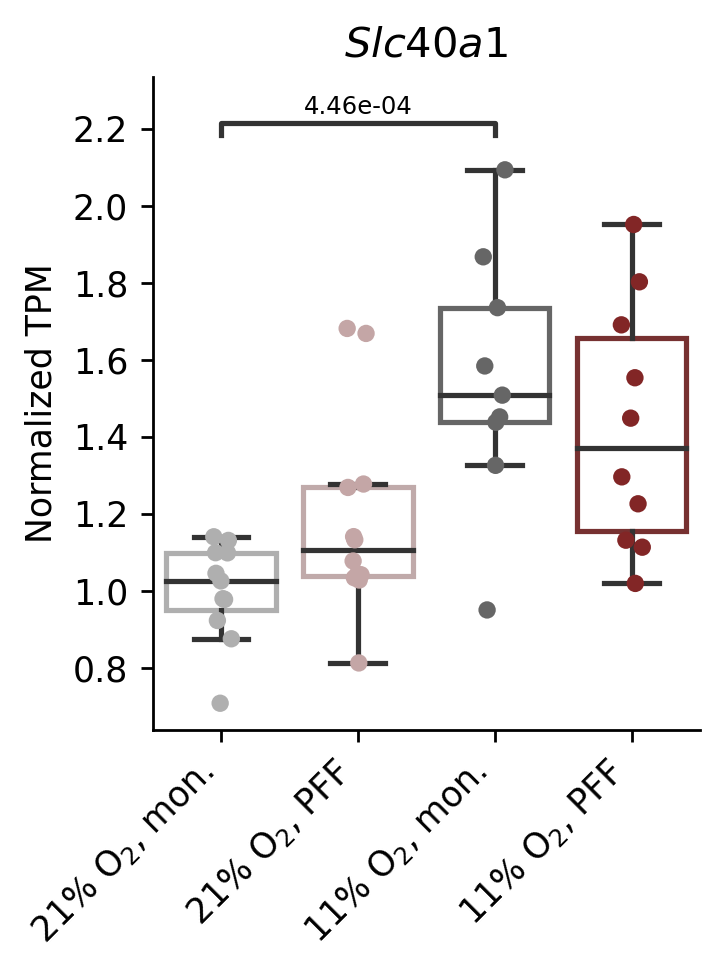

In [11]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(3,4), dpi=250)

plotting_params = {'data':to_plot, 'x':'exp_condition_disp', 'y':'Normalized TPM', 'order':hue_order, 
                   'hue':'exp_condition_disp', 'hue_order':hue_order, 'palette':color_dict, 'dodge':False}

seaborn.boxplot(**plotting_params, showfliers=False, ax=axes)
seaborn.stripplot(**plotting_params, ax=axes)

axes.set_xlabel('')
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_title('$\it{Slc40a1}$')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend_.remove()

# Add annotations
pairs = [('21% $\mathrm{O}_2$, mon.', '11% $\mathrm{O}_2$, mon.')]
pvals = rna_mono_hyp_vs_norm.set_index('common_name').loc[[goi], 'padj'].values
formatted_pvals = [f'{elt:0.2e}' for elt in pvals]
annotator = Annotator(axes, pairs, **plotting_params)
annotator.configure(verbose=False)
annotator._pvalue_format.fontsize = 7
annotator.set_custom_annotations(formatted_pvals)
annotator.annotate()

for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
    patch.set_edgecolor((r, g, b, 1))
    
#handles, labels = axes.get_legend_handles_labels()
#axes.legend(handles[-4:], labels[-4:], bbox_to_anchor=[1,1], frameon=False)

fig.tight_layout()

## TMT data

In [12]:
# load tmt sample metadata from Table S3
tmt_samples = pandas.read_excel('./Table S3.xlsx', sheet_name='sample metadata')
tmt_samples['mouse_id'] = tmt_samples['mouse_id'].astype(str)
tmt_samples = tmt_samples.set_index('mouse_id', drop=False)

# load protein metadata from Table S3
tmt_proteins = pandas.read_excel('./Table S3.xlsx', sheet_name='protein metadata', index_col=0)

# load raw counts from Table S3
tmt_norm = pandas.read_excel('./Table S3.xlsx', sheet_name='column sum norm outlier filt', index_col=0).T
tmt_norm.index = tmt_norm.index.astype(str)

# make AnnData object
tmt_data = anndata.AnnData(X=tmt_norm, obs=tmt_samples.loc[tmt_norm.index], var=tmt_proteins)
tmt_data.layers['data_norm'] = tmt_data.X.copy()

tmt_data

AnnData object with n_obs × n_vars = 13 × 8156
    obs: 'mouse_id', 'monomer_or_pff', 'o2_status', 'exp_condition', 'rep', 'Injection date', 'Harvest date', 'Pole test latency (sec)', 'Cage test latency (sec)', 'is_PCA_outlier'
    var: 'ProteinID', 'GeneSymbol', 'Description', 'Peptides', 'highly_variable'
    layers: 'data_norm'

In [13]:
disp_label_map = {'PFF_hypoxia':'11% $\mathrm{O}_2$, PFF', 'PFF_normoxia':'21% $\mathrm{O}_2$, PFF',
                  'monomer_hypoxia':'11% $\mathrm{O}_2$, mon.', 'monomer_normoxia':'21% $\mathrm{O}_2$, mon.'}
tmt_data.obs['exp_condition_disp'] = [disp_label_map[elt] for elt in tmt_data.obs['exp_condition'].values]
hue_order = ['21% $\mathrm{O}_2$, mon.', '21% $\mathrm{O}_2$, PFF', '11% $\mathrm{O}_2$, mon.', '11% $\mathrm{O}_2$, PFF']
color_list = [tuple(list(elt) + [1.0]) for elt in list(numpy.array([[176,176,176], [197,167,167], [102,102,102], [131,38,38]])/256)]
color_dict = dict(zip(hue_order, color_list))
print(color_list)

[(0.6875, 0.6875, 0.6875, 1.0), (0.76953125, 0.65234375, 0.65234375, 1.0), (0.3984375, 0.3984375, 0.3984375, 1.0), (0.51171875, 0.1484375, 0.1484375, 1.0)]


In [14]:
tmt_de_res = pandas.read_csv('./all_tmt_de_results.csv')
print(tmt_de_res.shape)
tmt_de_res.head()

(40780, 11)


,log2FoldChange,baseMean,stat,pvalue,padj,B,neg_log_pval,neg_log_padj,ProteinID,common_name,comparison
0,0.834930,9.963572,10.475675,2.928301e-07,0.002388,6.435096,6.533384,2.621907,P16406_7,Enpep,MonomerHypoxia_vs_MonomerNormoxia
1,0.700683,7.438739,8.011198,4.614196e-06,0.013150,4.291145,5.335904,1.881091,Q4FZG9_2,Ndufa4l2,MonomerHypoxia_vs_MonomerNormoxia
2,1.074818,6.380162,7.973335,4.836749e-06,0.013150,4.252301,5.315446,1.881091,A0A0A6YXW6_2,Igha,MonomerHypoxia_vs_MonomerNormoxia
3,0.539728,9.685264,7.730630,6.566880e-06,0.013270,3.998521,5.182641,1.877122,A0A0R4J101_5,Slc4a2,MonomerHypoxia_vs_MonomerNormoxia
4,0.437198,11.670114,7.563776,8.135254e-06,0.013270,3.819157,5.089629,1.877122,P55065_6,Pltp,MonomerHypoxia_vs_MonomerNormoxia


In [15]:
tmt_mono_hyp_vs_norm = pandas.read_excel('./Table S3.xlsx', sheet_name='monomer hyp vs monomer norm')
tmt_mono_hyp_vs_norm['comparison'] = 'MonomerHypoxia_vs_MonomerNormoxia'
tmt_mono_hyp_vs_norm['common_name'] = [elt.split('_')[0] for elt in tmt_mono_hyp_vs_norm['GeneID'].values]

tmt_mono_vs_pff_norm = pandas.read_excel('./Table S3.xlsx', sheet_name='PFF norm vs monomer norm')
tmt_mono_vs_pff_norm['comparison'] = 'PFFNormoxia_vs_MonomerNormoxia'
tmt_mono_vs_pff_norm['common_name'] = [elt.split('_')[0] for elt in tmt_mono_vs_pff_norm['GeneID'].values]

#### Fig 3f

In [16]:
goi = ['Vegfa', 'Kdr', 'Adm', 'Ldha', 'Cxcl12', 'Slc16a3', 'Ndufa4l2']
goi_filt = [elt for elt in goi if elt in tmt_data.var['GeneSymbol'].unique()]
goi_subset = tmt_data[:,tmt_data.var['GeneSymbol'].isin(goi_filt)].copy()
goi_subset.var['GeneSymbol'] = goi_subset.var['GeneSymbol'].astype(str)
goi_subset.var = goi_subset.var.reset_index().set_index('GeneSymbol', drop=False)

to_plot = tmt_data.obs.copy()
to_plot[goi_filt] = goi_subset.to_df(layer='data_norm')[goi_filt]

#normalize to 21% O2, mon.
to_plot[goi_filt] = to_plot[goi_filt].values/to_plot.loc[to_plot['exp_condition'] == 'monomer_normoxia', goi_filt].mean().values

to_plot = to_plot.melt(id_vars=['mouse_id', 'exp_condition_disp'], value_vars=goi_filt, var_name='GeneSymbol', value_name='Normalized intensity')
print(to_plot.shape)
to_plot.head()

(39, 4)


,mouse_id,exp_condition_disp,GeneSymbol,Normalized intensity
0,normoxia_mono_2,"21% $\mathrm{O}_2$, mon.",Ldha,1.059666
1,normoxia_mono_3,"21% $\mathrm{O}_2$, mon.",Ldha,1.006741
2,normoxia_mono_4,"21% $\mathrm{O}_2$, mon.",Ldha,0.933593
3,normoxia_PFF_1,"21% $\mathrm{O}_2$, PFF",Ldha,1.003932
4,normoxia_PFF_2,"21% $\mathrm{O}_2$, PFF",Ldha,0.985892


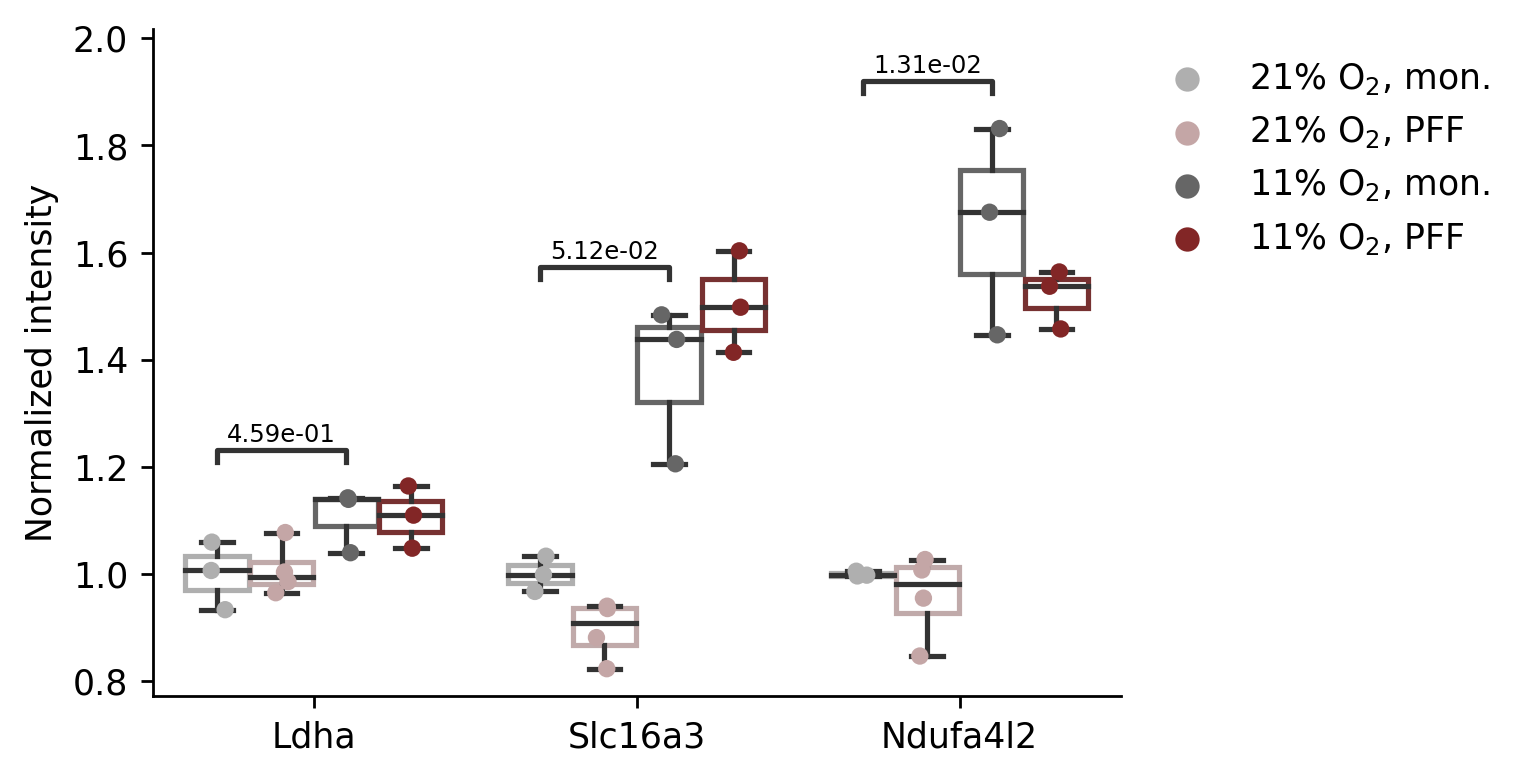

In [17]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,3), dpi=250, layout='constrained')

plotting_params = {'data':to_plot, 'x':'GeneSymbol', 'y':'Normalized intensity', 'order':goi_filt,
                   'hue':'exp_condition_disp', 'hue_order':hue_order, 'palette':color_dict}

seaborn.boxplot(**plotting_params, showfliers=False, ax=axes)
seaborn.stripplot(**plotting_params, dodge=True, ax=axes)

axes.set_xlabel('')
axes.set_xlim(-0.5,len(goi_filt)-0.5)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# Add annotations
pairs = [[(elt,'21% $\mathrm{O}_2$, mon.'), (elt, '11% $\mathrm{O}_2$, mon.')] for elt in goi_filt]
pvals = tmt_mono_hyp_vs_norm.set_index('common_name').loc[goi_filt, 'adj.P.Val'].values
formatted_pvals = [f'{elt:0.2e}' for elt in pvals]
annotator = Annotator(axes, pairs, **plotting_params)
annotator.configure(verbose=False)
annotator._pvalue_format.fontsize = 7
annotator.set_custom_annotations(formatted_pvals)
annotator.annotate()

for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
    patch.set_edgecolor((r, g, b, 1))
    
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[-4:], labels[-4:], bbox_to_anchor=[1,1], frameon=False)

fig.show()
#fig.tight_layout()

## Volcano plots

In [ ]:
rna_pff_vs_mono_norm = pandas.read_excel('./Table S2.xlsx', sheet_name='PFF norm vs monomer norm')
rna_pff_vs_mono_norm['comparison'] = 'PFFNormoxia_vs_MonomerNormoxia'
print(rna_pff_vs_mono_norm.shape)

rna_pff_vs_mono_hyp = pandas.read_excel('./Table S2.xlsx', sheet_name='PFF hyp vs monomer hyp')
rna_pff_vs_mono_hyp['comparison'] = 'PFFHypoxia_vs_MonomerHypoxia'
print(rna_pff_vs_mono_hyp.shape)

(13252, 11)


In [ ]:
cat_dtype = pandas.CategoricalDtype(categories=['NS', 'SigDown', 'SigUp'], ordered=True)
#cat_palette = {'NS':(202/256,202/256,202/256,1),
#               'SigDown':(43/256,57/256,142/256,1),
#               'SigUp':(189/256,32/256,47/256,1)}
cat_palette = {'NS':(202/256,202/256,202/256,1),
               'SigDown':(0,0,0,1),
               'SigUp':(0,0,0,1)}

In [ ]:
rna_pff_vs_mono_norm['sig_status2'] = 'NS'
rna_pff_vs_mono_norm.loc[(rna_pff_vs_mono_norm['padj'] < 0.05) 
                         & (rna_pff_vs_mono_norm['log2FoldChange'] > 0), 'sig_status2'] = 'SigUp'
rna_pff_vs_mono_norm.loc[(rna_pff_vs_mono_norm['padj'] < 0.05) 
                         & (rna_pff_vs_mono_norm['log2FoldChange'] < 0), 'sig_status2'] = 'SigDown'
rna_pff_vs_mono_norm['sig_status2'] = rna_pff_vs_mono_norm['sig_status2'].astype(cat_dtype)

In [ ]:
rna_pff_vs_mono_hyp['sig_status2'] = 'NS'
rna_pff_vs_mono_hyp.loc[(rna_pff_vs_mono_hyp['padj'] < 0.05) 
                         & (rna_pff_vs_mono_hyp['log2FoldChange'] > 0), 'sig_status2'] = 'SigUp'
rna_pff_vs_mono_hyp.loc[(rna_pff_vs_mono_hyp['padj'] < 0.05) 
                         & (rna_pff_vs_mono_hyp['log2FoldChange'] < 0), 'sig_status2'] = 'SigDown'
rna_pff_vs_mono_hyp['sig_status2'] = rna_pff_vs_mono_hyp['sig_status2'].astype(cat_dtype)

#### Fig 3a

In [ ]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(4,3.75), dpi=250)
seaborn.scatterplot(data=rna_pff_vs_mono_norm, x='log2FoldChange', y='neg_log10_padj', 
                    hue='sig_status2', palette=cat_palette, linewidth=0, ax=axes)

axes.set_xlim(-3,3)
axes.set_ylim(-1,22)

axes.legend_.remove()
axes.set_xlabel('$\mathrm{Log}_2$(PFF/Monomer)')
axes.set_ylabel('-$\mathrm{Log}_{10}$(padj)')
axes.set_title('21% $\mathrm{O}_2$')

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

fig.tight_layout()

#### Fig 3b

In [ ]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(4,3.75), dpi=250)
seaborn.scatterplot(data=rna_pff_vs_mono_hyp, x='log2FoldChange', y='neg_log10_padj', 
                    hue='sig_status2', palette=cat_palette, linewidth=0, ax=axes)

axes.set_xlim(-3,3)
axes.set_ylim(-1,22)

axes.legend_.remove()
axes.set_xlabel('$\mathrm{Log}_2$(PFF/Monomer)')
axes.set_ylabel('-$\mathrm{Log}_{10}$(padj)')
axes.set_title('11% $\mathrm{O}_2$')

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

fig.tight_layout()

## Venn diagrams

In [ ]:
hue_order = ['21% $\mathrm{O}_2$, mon.', '21% $\mathrm{O}_2$, PFF', '11% $\mathrm{O}_2$, mon.', '11% $\mathrm{O}_2$, PFF']
color_list = [tuple(list(elt) + [1.0]) for elt in list(numpy.array([[176,176,176], [197,167,167], [102,102,102], [131,38,38]])/256)]
color_dict = dict(zip(hue_order, color_list))

#### Fig S2a

In [ ]:
sig_down_mono_hyp_vs_mono_norm = set(rna_mono_hyp_vs_norm.loc[(rna_mono_hyp_vs_norm['log2FoldChange'] < -0.25)
                                                              & (rna_mono_hyp_vs_norm['padj'] < 0.05), 'Gene'].values)
sig_down_pff_norm_vs_mono_norm = set(rna_pff_vs_mono_norm.loc[(rna_pff_vs_mono_norm['log2FoldChange'] < -0.25)
                                                              & (rna_pff_vs_mono_norm['padj'] < 0.05), 'Gene'].values)

venn_sets = (sig_down_mono_hyp_vs_mono_norm - sig_down_pff_norm_vs_mono_norm,
             sig_down_pff_norm_vs_mono_norm - sig_down_mono_hyp_vs_mono_norm,
             sig_down_mono_hyp_vs_mono_norm & sig_down_pff_norm_vs_mono_norm)

venn_counts = tuple([len(elt) for elt in venn_sets])

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=250)
venn2(subsets=venn_counts, set_labels=('11% $\mathrm{O}_2$, monomer', '21% $\mathrm{O}_2$, PFF'), 
      set_colors=(color_dict['11% $\mathrm{O}_2$, mon.'], color_dict['21% $\mathrm{O}_2$, PFF']), 
      ax=axes)
venn_circs = venn2_circles(subsets=venn_counts, ax=axes)
axes.set_title('Significantly downregulated genes\ncompared to 21% $\mathrm{O}_2$, monomer')
fig.show()

#### Fig S2b

In [ ]:
sig_up_mono_hyp_vs_mono_norm = set(rna_mono_hyp_vs_norm.loc[(rna_mono_hyp_vs_norm['log2FoldChange'] > 0.25)
                                                            & (rna_mono_hyp_vs_norm['padj'] < 0.05), 'Gene'].values)
sig_up_pff_norm_vs_mono_norm = set(rna_pff_vs_mono_norm.loc[(rna_pff_vs_mono_norm['log2FoldChange'] > 0.25)
                                                            & (rna_pff_vs_mono_norm['padj'] < 0.05), 'Gene'].values)

venn_sets = (sig_up_mono_hyp_vs_mono_norm - sig_up_pff_norm_vs_mono_norm,
             sig_up_pff_norm_vs_mono_norm - sig_up_mono_hyp_vs_mono_norm,
             sig_up_mono_hyp_vs_mono_norm & sig_up_pff_norm_vs_mono_norm)

venn_counts = tuple([len(elt) for elt in venn_sets])

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=250)
venn2(subsets=venn_counts, set_labels=('11% $\mathrm{O}_2$, monomer', '21% $\mathrm{O}_2$, PFF'), 
      set_colors=(color_dict['11% $\mathrm{O}_2$, mon.'], color_dict['21% $\mathrm{O}_2$, PFF']), 
      ax=axes)
venn_circs = venn2_circles(subsets=venn_counts, ax=axes)
axes.set_title('Significantly upregulated genes\ncompared to 21% $\mathrm{O}_2$, monomer')
fig.show()

## Heatmaps

In [ ]:
disp_label_map = {'PFF_hypoxia':'11% $\mathrm{O}_2$, PFF', 'PFF_normoxia':'21% $\mathrm{O}_2$, PFF',
                  'monomer_hypoxia':'11% $\mathrm{O}_2$, mon.', 'monomer_normoxia':'21% $\mathrm{O}_2$, mon.'}
rna_data.obs['exp_condition_disp'] = [disp_label_map[elt] for elt in rna_data.obs['exp_condition'].values]
hue_order = ['21% $\mathrm{O}_2$, mon.', '21% $\mathrm{O}_2$, PFF', '11% $\mathrm{O}_2$, mon.', '11% $\mathrm{O}_2$, PFF']
color_list = [tuple(list(elt) + [1.0]) for elt in list(numpy.array([[176,176,176], [197,167,167], [102,102,102], [131,38,38]])/256)]
color_dict = dict(zip(hue_order, color_list))
print(color_list)

#### Downgoing genes -- Fig S2c

In [ ]:
# get genes of interest
sig_down_pff_norm_vs_mono_norm = rna_pff_vs_mono_norm.loc[(rna_pff_vs_mono_norm['log2FoldChange'] < -0.25)
                                                          & (rna_pff_vs_mono_norm['padj'] < 0.05), 'Gene'].values
gene_ids = [elt.split('_')[1] for elt in sig_down_pff_norm_vs_mono_norm]

# extract the data for these genes, compute the median expression across replicates, and z-score across samples
to_plot = rna_data[:,gene_ids].to_df(layer='tpm_counts_bc')
to_plot['exp_condition_disp'] = rna_data.obs['exp_condition_disp']
to_plot = to_plot.groupby('exp_condition_disp').median().loc[hue_order]
to_plot = to_plot.apply(stats.zscore)
print(to_plot.shape)
to_plot.head()

In [ ]:
# hierarchically cluster the genes
Z = fastcluster.linkage(to_plot.T)
leaf_order = hierarchy.leaves_list(Z)[::-1]

# plot as a heatmap
fig = pyplot.figure(figsize=(8,1), dpi=250)
ax_exp = fig.add_axes([0,0,0.9,1.0])
ax_cbar = fig.add_axes([0.92,0.05,0.015,0.9])
img = ax_exp.matshow(to_plot.values[:,leaf_order], cmap='bwr', vmin=-1.5, vmax=1.5, aspect='auto')
ax_exp.set_xticks([])
ax_exp.set_xticklabels([])
ax_exp.set_yticks(numpy.arange(to_plot.shape[0]))
ax_exp.set_yticklabels(to_plot.index.values)
ax_exp.set_title(f'Downgoing genes (n={to_plot.shape[1]}) in 21% $\mathrm{{O}}_2$, PFF vs 21% $\mathrm{{O}}_2$, mon.')
fig.colorbar(img, cax=ax_cbar)
ax_cbar.set_ylabel('Z-scored median\nTPMs', fontsize=10)
fig.show()

#### Upgoing genes -- Fig S2d

In [ ]:
# get genes of interest
sig_up_pff_norm_vs_mono_norm = rna_pff_vs_mono_norm.loc[(rna_pff_vs_mono_norm['log2FoldChange'] > 0.25)
                                                        & (rna_pff_vs_mono_norm['padj'] < 0.05), 'Gene'].values
gene_ids = [elt.split('_')[1] for elt in sig_up_pff_norm_vs_mono_norm]

# extract the data for these genes, compute the median expression across replicates, and z-score across samples
to_plot = rna_data[:,gene_ids].to_df(layer='tpm_counts_bc')
to_plot['exp_condition_disp'] = rna_data.obs['exp_condition_disp']
to_plot = to_plot.groupby('exp_condition_disp').median().loc[hue_order]
to_plot = to_plot.apply(stats.zscore)
print(to_plot.shape)
to_plot.head()

In [ ]:
# hierarchically cluster the genes
Z = fastcluster.linkage(to_plot.T)
leaf_order = hierarchy.leaves_list(Z)[::-1]

# plot as a heatmap
fig = pyplot.figure(figsize=(8,1), dpi=250)
ax_exp = fig.add_axes([0,0,0.9,1.0])
ax_cbar = fig.add_axes([0.92,0.05,0.015,0.9])
img = ax_exp.matshow(to_plot.values[:,leaf_order], cmap='bwr', vmin=-1.5, vmax=1.5, aspect='auto')
ax_exp.set_xticks([])
ax_exp.set_xticklabels([])
ax_exp.set_yticks(numpy.arange(to_plot.shape[0]))
ax_exp.set_yticklabels(to_plot.index.values)
ax_exp.set_title(f'Upgoing genes (n={to_plot.shape[1]}) in 21% $\mathrm{{O}}_2$, PFF vs 21% $\mathrm{{O}}_2$, mon.')
fig.colorbar(img, cax=ax_cbar)
ax_cbar.set_ylabel('Z-scored median\nTPMs', fontsize=10)
fig.show()

## RNA-seq batch-corrected and non-batch-corrected PCA plots

In [ ]:
rna_data.obs['batch'] = rna_data.obs['batch'].astype(str)

In [ ]:
rna_data.X = rna_data.layers['tpm_counts_bc'].copy()

sc.pp.log1p(rna_data)
rna_data.layers['logtpm_counts_bc'] = rna_data.X.copy()

In [ ]:
min_mean = 1.25
max_mean = 7
min_disp = 1.5

sc.pp.highly_variable_genes(rna_data, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
sc.pl.highly_variable_genes(rna_data)
print('Found {!s} highly variable genes.'.format(rna_data.var['highly_variable'].sum()))

In [ ]:
sc.pp.scale(rna_data, max_value=10)
rna_data.layers['logtpm_scaled_counts_bc'] = rna_data.X.copy()

sc.tl.pca(rna_data, n_comps=41, svd_solver='arpack')

In [ ]:
# generate a second anndata object with the non-batch-corrected PCA
rna_data.X = rna_data.layers['tpm_counts'].copy()
sc.pp.log1p(rna_data)
sc.pp.scale(rna_data, max_value=10)
rna_data.layers['logtpm_scaled_counts'] = rna_data.X.copy()

rna_data2 = sc.tl.pca(rna_data, n_comps=41, svd_solver='arpack', copy=True)

In [ ]:
# plot both PCAs in the same figure
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

pyplot.rc('font', size=SMALL_SIZE)          # controls default text sizes
pyplot.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
pyplot.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
pyplot.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
pyplot.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

hue_order1 = ['PFF_hypoxia', 'PFF_normoxia', 'monomer_hypoxia', 'monomer_normoxia'] 
hue_order2 = ['1', '2', '3']

fig, axes = pyplot.subplots(nrows=2, ncols=2, figsize=(12,12), dpi=600)

to_plot = rna_data2.obs.copy()
to_plot[['PC1', 'PC2']] = rna_data2.obsm['X_pca'][:,:2]
pc1_var_exp, pc2_var_exp = rna_data2.uns['pca']['variance_ratio'][:2]
seaborn.scatterplot(data=to_plot, x='PC1', y='PC2', hue='exp_condition', hue_order=hue_order1, ax=axes[0,0])
axes[0,0].set_title('No batch correction\ncolored by experimental condition')
axes[0,0].set_xlabel(f'PC1 ({round(pc1_var_exp*100, 2)}%)')
axes[0,0].set_ylabel(f'PC2 ({round(pc2_var_exp*100, 2)}%)')
axes[0,0].legend(frameon=False)
seaborn.scatterplot(data=to_plot, x='PC1', y='PC2', hue='batch', hue_order=hue_order2, ax=axes[0,1])
axes[0,1].set_title('No batch correction\ncolored by batch')
axes[0,1].set_xlabel(f'PC1 ({round(pc1_var_exp*100, 2)}%)')
axes[0,1].set_ylabel(f'PC2 ({round(pc2_var_exp*100, 2)}%)')
axes[0,1].legend(frameon=False)

to_plot = rna_data.obs.copy()
to_plot[['PC1', 'PC2']] = rna_data.obsm['X_pca'][:,:2]
pc1_var_exp, pc2_var_exp = rna_data.uns['pca']['variance_ratio'][:2]
seaborn.scatterplot(data=to_plot, x='PC1', y='PC2', hue='exp_condition', hue_order=hue_order1, ax=axes[1,0])
axes[1,0].set_title('Batch corrected\ncolored by experimental condition')
axes[1,0].set_xlabel(f'PC1 ({round(pc1_var_exp*100, 2)}%)')
axes[1,0].set_ylabel(f'PC2 ({round(pc2_var_exp*100, 2)}%)')
axes[1,0].get_legend().remove()
seaborn.scatterplot(data=to_plot, x='PC1', y='PC2', hue='batch', hue_order=hue_order2, ax=axes[1,1])
axes[1,1].set_title('Batch corrected\ncolored by batch')
axes[1,1].set_xlabel(f'PC1 ({round(pc1_var_exp*100, 2)}%)')
axes[1,1].set_ylabel(f'PC2 ({round(pc2_var_exp*100, 2)}%)')
axes[1,1].get_legend().remove()

for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()